In [1]:
import sys, os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax.scipy.stats.gamma import sf as gamma_sf
from jax.scipy.stats.norm import pdf as norm_pdf

import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob, c_gamma_sf, c_multi_gamma_prob, c_multi_gamma_sf
from lib.gamma_sf_approx import gamma_sf_fast
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [3]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [4]:
dist = 50.0
z = -500
rho = 0.0
zenith = 1.57
azimuth = 3.9264083

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

print(gamma_a)
print(gamma_b)

[2.73251134 5.05679516 1.41002788]
[0.01810005 0.101793   0.00198738]


In [5]:
p_coeffs = jnp.array([
    9.4368392235e-3,
    -1.0782666481e-4,
    -5.8969657295e-6,
    2.8939523781e-7,
    1.0043326298e-1,
    5.5637848465e-1
])

q_coeffs = jnp.array([
    1.1464706419e-1,
    2.6963429121,
    -2.9647038257,
    2.1080724954
])

r_coeffs = jnp.array([
    0.0,
    1.1428716184,
    -6.6981186438e-3,
    1.0480765092e-4
])

s_coeffs = jnp.array([
    1.0480765092,
    2.3423452308,
    -3.6174503174e-1,
    -3.1376557650,
    2.9092306039
])

In [6]:
def c_coeffs(a):
    ap2 = jnp.power(a, 2)
    ap3 = jnp.power(a, 3)
    ap4 = jnp.power(a, 4)
    
    c1 = 1.0 + p_coeffs[0]*a + p_coeffs[1]*ap2 + p_coeffs[2]*ap3 + p_coeffs[3]*ap4 + p_coeffs[4]*(jnp.exp(-p_coeffs[5]*a)-1.0)
    c2 = q_coeffs[0] + q_coeffs[1]/a + q_coeffs[2]/ap2 + q_coeffs[3]/ap3
    c3 = r_coeffs[0] + r_coeffs[1]*a + r_coeffs[2]*ap2 + r_coeffs[3]*ap3
    c4 = s_coeffs[0] + s_coeffs[1]/a + s_coeffs[2]/ap2 + s_coeffs[3]/ap3 + s_coeffs[4]/ap4
    return jnp.array([c1, c2, c3, c4])

In [7]:
def lower_incomplete_gamma_approx(x, a):
    c = c_coeffs(a)
    w = 0.5 + 0.5 * jnp.tanh(c[1]*(x-c[2]))

    # could use approx tanh function. but did not observe speed-up.
    #w = 0.5 + 0.5 * tanh_approx(c[1]*(x-c[2]))
    
    r1 = jnp.exp(-x)*jnp.power(x, a)*(1.0/a + c[0]*x/(a*(a+1)) + (c[0]*x)**2/(a*(a+1)*(a+2)))*(1-w) 
    r2 = jax.scipy.special.gamma(a)*w*(1.0-jnp.power(c[3], -x))

    #r1 = 1./jax.scipy.special.gamma(a)*jnp.exp(-x)*jnp.power(x, a)*(1.0/a + c[0]*x/(a*(a+1)) + (c[0]*x)**2/(a*(a+1)*(a+2)))*(1-w) 
    #r2 = w*(1.0-jnp.power(c[3], -x))
    return r1+r2 

In [8]:
def tanh_approx(x):
    ct = 9.37532
    crit = ct / 3
    y = (9*ct**2*x + 27*x**3) / (ct**3 + 27*ct*x**2)
    y = jnp.where(x <= -crit, -1.0, y)
    y = jnp.where(x >= crit, 1.0, y)
    return y

In [9]:
a = 1.0001
print(lower_incomplete_gamma_approx(0.5, a)/jax.scipy.special.gamma(a))
#print(lower_incomplete_gamma_approx(0.5, a))

0.38937461015076913


In [10]:
print(jax.scipy.special.gammainc(a, 0.5))

0.3934203965437311


In [11]:
def gamma_sf_approx(x, a, b):
    return jnp.clip(1.0-lower_incomplete_gamma_approx(x*b, a)/jax.scipy.special.gamma(a), min=0.0, max=1.0)
    

In [12]:
print(gamma_sf_approx(5, gamma_a, gamma_b))

[0.99930151 0.99917853 0.99870301]


In [13]:
print(gamma_sf(5, gamma_a, scale=1/gamma_b))

[0.99969551 0.99983708 0.99880736]


In [14]:
def c_multi_gamma_mpe_prob_pure_jax_approx(x, mix_probs, a, b, n, sigma=3.0):
    nmax = 20
    nint = 101
    eps = 1.e-6

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))

    xvals = jnp.linspace(xmin+eps, xmax, nint)
    n_pdf = norm_pdf(0.5*(xvals[:-1]+xvals[1:]), loc=x, scale=sigma)

    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)

    xvals_e = jnp.expand_dims(xvals, axis=0)
    sfs = jnp.sum(mix_probs_e * gamma_sf_fast(xvals_e, a_e, b_e), axis=0)
    sfs_power_n = jnp.power(sfs, n)
    return jnp.sum(n_pdf * (sfs_power_n[:-1]-sfs_power_n[1:]))

convolved_mpe_triple_gamma_approx_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax_approx, (0, None, None, None, None, None), 0))


def c_multi_gamma_mpe_prob_pure_jax(x, mix_probs, a, b, n, sigma=3.0):
    nmax = 20
    nint = 101
    eps = 1.e-6

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))

    xvals = jnp.linspace(xmin+eps, xmax, nint)
    n_pdf = norm_pdf(0.5*(xvals[:-1]+xvals[1:]), loc=x, scale=sigma)

    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)

    xvals_e = jnp.expand_dims(xvals, axis=0)
    sfs = jnp.sum(mix_probs_e * gamma_sf(xvals_e, a_e, scale=1.0/b_e), axis=0)
    sfs_power_n = jnp.power(sfs, n)
    return jnp.sum(n_pdf * (sfs_power_n[:-1]-sfs_power_n[1:]))

convolved_mpe_triple_gamma_v1d_x = jax.jit(jax.vmap(c_multi_gamma_mpe_prob_pure_jax, (0, None, None, None, None, None), 0))

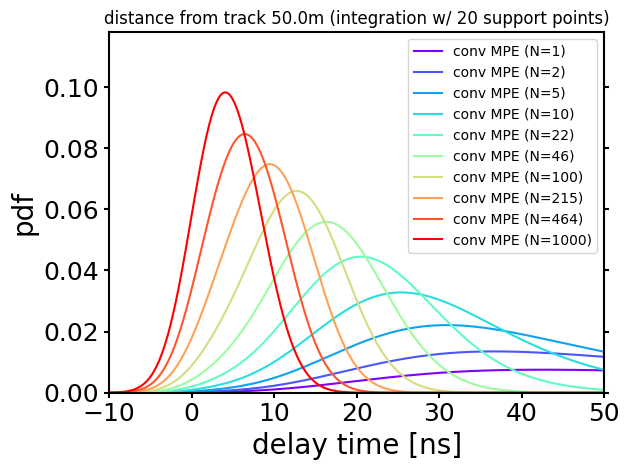

In [15]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 50, 1000)

y_max = 0
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = convolved_mpe_triple_gamma_approx_v1d_x(xvals, mix_probs, gamma_a, gamma_b, n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])

plot_args = {'xlim':[-10, 50],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.show()

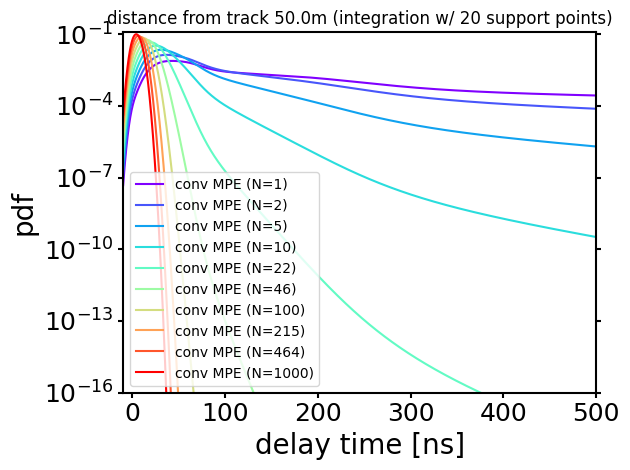

In [16]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-20, 500, 10000)

y_max = 0
n_photons = jnp.array(np.logspace(0.0, 3.0, 10))
color = cm.rainbow(np.linspace(0, 1, len(n_photons)))

for i, n_p in enumerate(n_photons):
    ys = convolved_mpe_triple_gamma_approx_v1d_x(xvals, mix_probs, gamma_a, gamma_b, n_p, jnp.array(3.0))
    plt.plot(xvals, ys, label=f'conv MPE (N={n_p:.0f})', color=color[i])
    y_max = np.amax([y_max, np.amax(ys)])

plot_args = {'xlim':[-10, 500],
                     'ylim':[1.e-16, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}

adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_yscale('log')
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.show()

In [17]:
xvals = np.linspace(-20, 50, 1000000)

In [18]:
#%timeit convolved_mpe_triple_gamma_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 10, jnp.array(3.0)).block_until_ready()

In [19]:
%timeit convolved_mpe_triple_gamma_approx_v1d_x(xvals, mix_probs, gamma_a, gamma_b, 10, jnp.array(3.0)).block_until_ready()

325 ms ± 194 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
592/17


34.8235294117647